In [9]:
import pytse_client as tse
import numpy as np
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
# tickers = tse.download(symbols="all", write_to_csv=True)

Device = ("cuda"
          if torch.cuda.is_available()
          else "cpu"
)
print(f"Using {Device} device")
days_history=60
days_predict=20

Using cuda device


In [10]:
class Model(nn.Module):
    def __init__(self,input_size,output_size):
        n=16
        m=8
        kernel=[5,5]
        pad=[2,2]
        super().__init__()
        self.conv1= nn.Conv2d(1,m,kernel_size=kernel,padding=pad)
        self.conv2= nn.Conv2d(m,2*m,kernel_size=kernel,padding=pad)
        self.conv3= nn.Conv2d(2*m,4*m,kernel_size=kernel,padding=pad)
        self.conv44=nn.Conv2d(4*m,4*m,kernel_size=kernel,padding=pad)
        self.conv4= nn.Conv2d(4*m,2*m,kernel_size=kernel,padding=pad)
        self.conv5= nn.Conv2d(2*m,m,kernel_size=kernel,padding=pad)
        self.Lin1 = nn.Linear(input_size*5*m,2*n)
        self.kqv =  nn.Linear(input_size*5*m,input_size*5*m)
        self.Lin2 = nn.Linear(2*n,4*n)
        self.Lin3 = nn.Linear(4*n,2*n)
        self.Lin4 = nn.Linear(2*n,n)
        self.Lin5 = nn.Linear(n,output_size)
        self.activation1 = nn.LeakyReLU(negative_slope=0.01)
        self.activation2 = nn.Tanh()
        self.drop = nn.Dropout(p=0.1)
        self.norminput = nn.BatchNorm2d(1)
        self.normC = nn.BatchNorm2d(4*m)
        self.normL2 = nn.BatchNorm1d(4*n)
        self.normL3 = nn.BatchNorm1d(2*n)
        self.normL4 = nn.BatchNorm1d(1*n)
        self.flat = nn.Flatten(start_dim=1)
        self.multi = nn.MultiheadAttention(input_size*5*m,4)
    def forward(self, x):
        x = self.norminput(x)
        x = self.conv1(x)
        x = self.activation1(x)
        x = self.drop(x) ###
        x = self.conv2(x)
        x = self.activation1(x)
        x = self.drop(x) ###
        x = self.conv3(x)
        x = self.activation1(x)
        x = self.drop(x) ###
        for i in range(1):
            #x_ = x
            x = self.conv44(x)
            x = self.activation1(x)
            x = self.drop(x) ###
            x = self.normC(x) #### 
            #x = x + x_

        x = self.conv4(x)
        x = self.activation1(x)
        x = self.drop(x) ###
        x = self.conv5(x)
        x = self.activation1(x)
        x = self.drop(x) ###
        x = self.flat(x)
        '''
        k = self.kqv(x)
        q = self.kqv(x)
        v = self.kqv(x)
        x = self.multi(q,k,v)
        x = x[0]
        '''
    
        x = self.Lin1(x)
        x = self.activation1(x) 
        x = self.drop(x) ###
        x = self.Lin2(x)
        x = self.activation1(x)
        x = self.normL2(x)#######
        x = self.drop(x) ###
        x = self.Lin3(x)
        x = self.activation2(x)
        x = self.normL3(x)#######
        x = self.drop(x) ###
        x = self.Lin4(x)
        x = self.activation2(x)
        x = self.normL4(x)#######
        x = self.drop(x) ###
        x = self.Lin5(x)
        #x = self.activation1(x)
        x = self.drop(x) ###
        return x

model=Model(days_history,days_predict).to(device=Device)
optimizer = torch.optim.Adam(model.parameters(),lr=0.001)
LossFn = nn.HuberLoss()
gama=0.99
W_gama=torch.diag(torch.tensor([gama**(1*i) for i in range(days_predict)],device=Device))
#for p in model.parameters():
#    p.data.fill_(torch.randn([])/10)

In [11]:
names = ["آباد","آپ","اپرداز","آساس","افرا","اهرم","انرژی","بترانس","بنیرو","پترول"]
sym= names[0]
#sym="وبملت"

ticker=tse.Ticker(sym)
length=ticker.history.shape[0]
train_length = int(np.floor(length*0.70))
test_length = length - train_length

# Now we extract some portion of the first sequences of data for train
X_train=np.zeros([train_length - days_history - days_predict , days_history,5])
Y_train=np.zeros([train_length - days_history - days_predict , days_predict])
for i in range(train_length - days_history - days_predict):
    m = ticker.history.loc[i : i + days_history - 1].to_numpy()
    start_day_price = m[0,9]
    X_train[i,:,:] = np.array([m[:,9]/start_day_price , m[:,7]/1e3 , m[:,6]/1e6 , m[:,2]/m[0,2] , m[:,3]/m[0,3]]).T
    m = ticker.history.loc[i + days_history : i + days_history - 1 + days_predict].to_numpy()
    Y_train[i,:] = m[:,9]/start_day_price

# Now we extract some portion of the last sequences of data for test
X_test=np.zeros([test_length - days_predict , days_history, 5])
Y_test=np.zeros([test_length - days_predict , days_predict])
for i in range(test_length - days_predict):
    j = i + train_length - days_history
    m = ticker.history.loc[j : j + days_history - 1].to_numpy()
    start_day_price = m[0,9]
    X_test[i,:,:] = np.array([m[:,9]/start_day_price , m[:,7]/1e3 , m[:,6]/1e6 , m[:,2]/m[0,2] , m[:,3]/m[0,3]]).T
    m = ticker.history.loc[j + days_history : j + days_history - 1 + days_predict].to_numpy()
    Y_test[i,:] = m[:,9]/start_day_price

train_arr = np.arange(train_length - days_history - days_predict - 1)
train_idx = np.random.permutation(train_arr)
X_train = X_train[train_idx]
Y_train = Y_train[train_idx]

test_arr = np.arange(test_length - days_predict - 1)
test_idx = np.random.permutation(test_arr)
X_test = X_test[test_idx]
Y_test = Y_test[test_idx]
X_train = torch.from_numpy(X_train).to(device=Device,dtype=torch.float32)
Y_train = torch.from_numpy(Y_train).to(device=Device,dtype=torch.float32)

X_test = torch.from_numpy(X_test).to(device=Device,dtype=torch.float32)
Y_test = torch.from_numpy(Y_test).to(device=Device,dtype=torch.float32)

iidx=np.random.randint(test_length-days_predict,size=[5,2])

In [14]:
batch_size = 40
train_Losses=[]
test_Losses=[]
N_train = int(np.floor(X_train.size(0)/batch_size))
N_test = int(np.floor(X_test.size(0)/batch_size))

for epoch in range(20):
    model.train()
    train_loss=torch.tensor(0,dtype=torch.float32)
    for i in range(N_train):
        x = X_train[i*batch_size:(i+1)*batch_size,:,:].unsqueeze(1)
        y = Y_train[i*batch_size:(i+1)*batch_size,:]
        optimizer.zero_grad()
        out = model(x) + y[:,0].unsqueeze(1)
        loss_train = LossFn(y@W_gama,out@W_gama)
        loss_train.backward()
        #nn.utils.clip_grad_norm(model.parameters(),1)
        optimizer.step()
        train_loss += loss_train.detach().item()
    train_Losses.append( train_loss/N_train )
   
    model.eval()
    test_loss=torch.tensor(0,dtype=torch.float32)
    test_acc=torch.tensor(0,dtype=torch.float32)
    with torch.no_grad():
        for i in range(N_test):
            x = X_test[i*batch_size:(i+1)*batch_size,:,:].unsqueeze(1)
            y = Y_test[i*batch_size:(i+1)*batch_size,:].detach()
            out = model(x) + y[:,0].unsqueeze(1) 
            loss_test = LossFn(y@W_gama,out@W_gama)
            test_loss += loss_test.detach().item()
            temp=y-out
            test_acc += torch.sum(1-torch.abs(y-out)/y).detach().item()
    test_Losses.append( test_loss/N_test )
    accuracy = test_acc / (N_test*batch_size*days_predict) *100
    print(f'{epoch}: train loss is {train_Losses[epoch]} & test loss is {test_Losses[epoch]} & accuracy is %{accuracy}')

0: train loss is 0.007549387868493795 & test loss is 0.025466596707701683 & accuracy is %52.93667984008789
1: train loss is 0.007488045375794172 & test loss is 0.026116086170077324 & accuracy is %51.73206329345703
2: train loss is 0.007164318580180407 & test loss is 0.02678539790213108 & accuracy is %49.324363708496094
3: train loss is 0.007212703116238117 & test loss is 0.028996851295232773 & accuracy is %49.315948486328125
4: train loss is 0.007054905407130718 & test loss is 0.027976786717772484 & accuracy is %49.894100189208984
5: train loss is 0.0068667116574943066 & test loss is 0.02791907638311386 & accuracy is %48.129295349121094
6: train loss is 0.0067680710926651955 & test loss is 0.026950934901833534 & accuracy is %48.74808883666992
7: train loss is 0.006837212480604649 & test loss is 0.029108742251992226 & accuracy is %45.10307693481445
8: train loss is 0.006712920032441616 & test loss is 0.028590654954314232 & accuracy is %47.765262603759766
9: train loss is 0.0064431219361

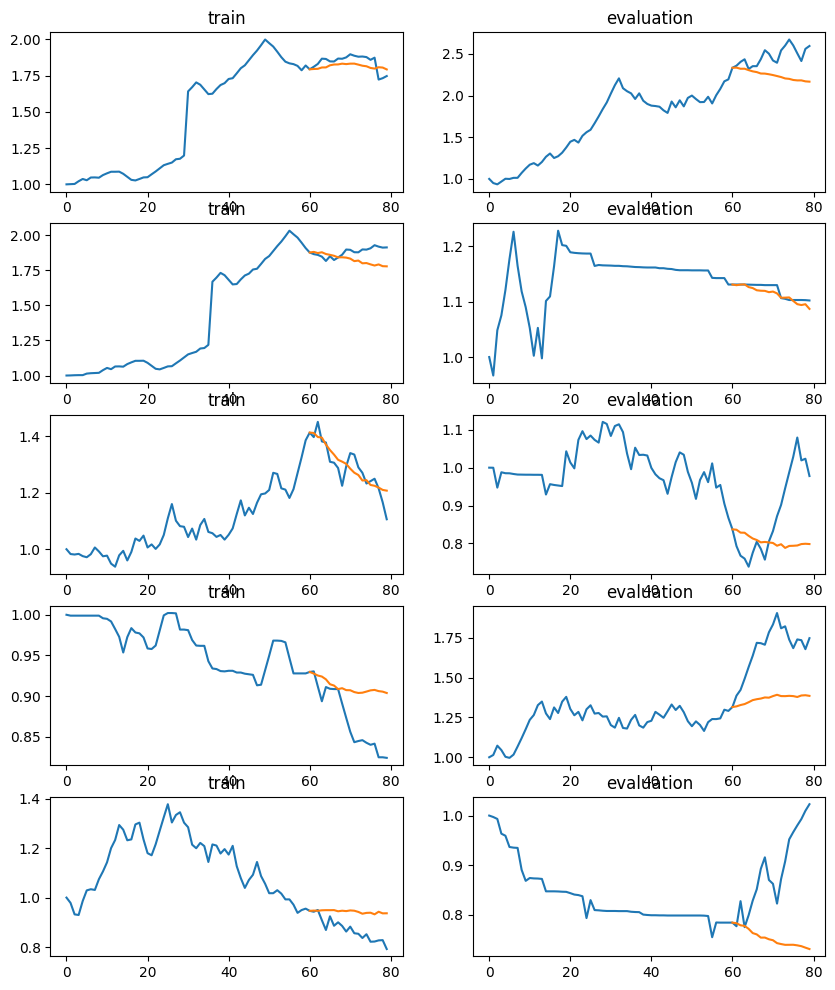

In [15]:
plt.figure(figsize=[10,12])
model.eval()
for i in range(5):
   plt.subplot(5,2,2*i+1)
   r=iidx[i,0]
   yy=torch.concatenate([X_train[r,:,0].cpu(),Y_train[r,:].cpu()])
   xx=np.arange(days_history+days_predict)
   plt.plot(xx,yy)
   tempp=X_train[r,:,:].unsqueeze(0).unsqueeze(0)
   #yyy=(model(tempp).detach()).squeeze(0).cpu()  
   yyy=( (model(tempp).detach()+Y_train[r,0]) ).squeeze(0).cpu()
   plt.plot(xx[days_history:days_history+days_predict] ,yyy )
   plt.title('train')

   plt.subplot(5,2,2*i+2)
   r=iidx[i,1]
   yy=torch.concatenate([X_test[r,:,0].cpu(),Y_test[r,:].cpu()])
   xx=np.arange(days_history+days_predict)
   plt.plot(xx,yy)
   tempp=X_test[r,:,:].unsqueeze(0).unsqueeze(0)
   #yyy=(model(tempp).detach()).squeeze(0).cpu()  
   yyy=( (model(tempp).detach()+Y_test[r,0]) ).squeeze(0).cpu()
   plt.plot(xx[days_history:days_history+days_predict] ,yyy )
   plt.title('evaluation')




